In [120]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [121]:
# google trends
def merge_and_normalize_trends(dfs, col_name):
    # Start with the first DataFrame
    result = dfs[0].copy()
    for next_df in dfs[1:]:
        # Find overlap
        overlap = set(result["Woche"]) & set(next_df["Woche"])
        if overlap:
            # Use the mean ratio in the overlap to normalize
            overlap = list(overlap)
            result_overlap = result[result["Woche"].isin(overlap)].set_index("Woche")
            next_overlap = next_df[next_df["Woche"].isin(overlap)].set_index("Woche")
            ratio = result_overlap[col_name].mean() / next_overlap[col_name].mean()
        else:
            ratio = 1.0
        # Normalize next_df
        next_df_norm = next_df.copy()
        next_df_norm[col_name] = next_df_norm[col_name] * ratio
        # Append only non-overlapping part
        non_overlap = ~next_df_norm["Woche"].isin(result["Woche"])
        result = pd.concat([result, next_df_norm[non_overlap]], ignore_index=True)
    # Sort by date
    result = result.sort_values("Woche").reset_index(drop=True)
    return result

# Keyword: "Auto Finanzierung"
gt_auto_finanzierung_1 = pd.read_csv('./original_data/gt_auto_finanzierung_1.csv')
gt_auto_finanzierung_2 = pd.read_csv('./original_data/gt_auto_finanzierung_2.csv')
gt_auto_finanzierung_3 = pd.read_csv('./original_data/gt_auto_finanzierung_3.csv')

gt_auto_finanzierung = merge_and_normalize_trends(
  [gt_auto_finanzierung_1, gt_auto_finanzierung_2, gt_auto_finanzierung_3],
  col_name="Auto Finanzierung"
)
gt_auto_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "BMW Finanzierung"
gt_bmw_finanzierung_1 = pd.read_csv('./original_data/gt_bmw_finanzierung_1.csv')
gt_bmw_finanzierung_2 = pd.read_csv('./original_data/gt_bmw_finanzierung_2.csv')
gt_bmw_finanzierung_3 = pd.read_csv('./original_data/gt_bmw_finanzierung_3.csv')

gt_bmw_finanzierung = merge_and_normalize_trends(
  [gt_bmw_finanzierung_1, gt_bmw_finanzierung_2, gt_bmw_finanzierung_3],
  col_name="BMW Finanzierung"
)
gt_bmw_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "Auto Leasing"
gt_auto_leasing_1 = pd.read_csv('./original_data/gt_auto_leasing_1.csv')
gt_auto_leasing_2 = pd.read_csv('./original_data/gt_auto_leasing_2.csv')
gt_auto_leasing_3 = pd.read_csv('./original_data/gt_auto_leasing_3.csv')

gt_auto_leasing = merge_and_normalize_trends(
  [gt_auto_leasing_1, gt_auto_leasing_2, gt_auto_leasing_3],
  col_name="Auto Leasing"
)
gt_auto_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "BMW Leasing"
gt_bmw_leasing_1 = pd.read_csv('./original_data/gt_bmw_leasing_1.csv')
gt_bmw_leasing_2 = pd.read_csv('./original_data/gt_bmw_leasing_2.csv')
gt_bmw_leasing_3 = pd.read_csv('./original_data/gt_bmw_leasing_3.csv')
gt_bmw_leasing = merge_and_normalize_trends(
  [gt_bmw_leasing_1, gt_bmw_leasing_2, gt_bmw_leasing_3],
  col_name="BMW Leasing"
)
gt_bmw_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "Leasing"
gt_leasing_1 = pd.read_csv('./original_data/gt_leasing_1.csv')
gt_leasing_2 = pd.read_csv('./original_data/gt_leasing_2.csv')
gt_leasing_3 = pd.read_csv('./original_data/gt_leasing_3.csv')
gt_leasing = merge_and_normalize_trends(
  [gt_leasing_1, gt_leasing_2, gt_leasing_3],
  col_name="leasing"
)
gt_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
# Keyword: "BMW"
gt_bmw_1 = pd.read_csv('./original_data/gt_bmw_1.csv')
gt_bmw_2 = pd.read_csv('./original_data/gt_bmw_2.csv')
gt_bmw_3 = pd.read_csv('./original_data/gt_bmw_3.csv')
gt_bmw = merge_and_normalize_trends(
  [gt_bmw_1, gt_bmw_2, gt_bmw_3],
  col_name="BMW"
)
gt_bmw.rename(columns={"Woche": "DATE"}, inplace=True)


In [122]:
# apgi
apgi = pd.read_csv('./original_data/apgi.csv')

apgi['DATE'] = pd.to_datetime(apgi['DATE'], format='%Y-%m') + pd.offsets.MonthEnd(0)
apgi['DATE'] = apgi['DATE'].dt.strftime('%Y-%m-%d')

In [123]:
# arbeitslosenzahlen
arbeitslosenquote = pd.read_csv("./original_data/arbeitslosenzahlen.csv", sep=";", decimal=",")

# Clean integer columns (remove dots, convert to int)
for col in ["Bestand Arbeitslose", "Zugang Arbeitslose", "Abgang Arbeitslose"]:
  arbeitslosenquote[col] = arbeitslosenquote[col].astype(str).str.replace(".", "", regex=False).replace("", "0").astype(int)

# Clean float column (replace comma with dot, convert to float)
arbeitslosenquote["Arbeitslosenquote"] = arbeitslosenquote["Arbeitslosenquote"].astype(str).str.replace(",", ".", regex=False).replace("", "0").astype(float)

# Convert 'Berichtsmonat' to datetime
arbeitslosenquote["DATE"] = arbeitslosenquote["Berichtsmonat"].astype(str).apply(
  lambda x: pd.to_datetime(
    f"{x.split(' ')[1]}-{month_map.get(x.split(' ')[0], '01')}-01", errors="coerce"
  )
)
arbeitslosenquote["DATE"] = arbeitslosenquote["DATE"] + pd.offsets.MonthEnd(0)

# Reorder columns
arbeitslosenquote = arbeitslosenquote.drop(columns=["Berichtsmonat"])
arbeitslosenquote = arbeitslosenquote[["DATE"] + [col for col in arbeitslosenquote.columns if col != "DATE"]]

arbeitslosenquote


,DATE,Bestand Arbeitslose,Zugang Arbeitslose,Abgang Arbeitslose,Arbeitslosenquote
0,2025-04-30,2931550,562010,597530,6.3
1,2025-03-31,2967080,577380,599530,6.4
2,2025-02-28,2989220,585600,589050,6.4
3,2025-01-31,2992660,625980,439960,6.4
4,2024-12-31,2806630,562260,529670,6.0
...,...,...,...,...,...
211,2007-09-30,3530640,673130,834200,8.4
212,2007-08-31,3691890,671520,680410,8.8
213,2007-07-31,3701000,775270,746800,8.8
214,2007-06-30,3672930,578000,700850,8.8


In [124]:
# euribor
# 3 months
euribor_3m = pd.read_csv('./original_data/euribor_3m.csv')
euribor_3m = euribor_3m.drop(columns=['TIME PERIOD'])
euribor_3m = euribor_3m.rename(
    columns={
        "Euribor 3-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA)": "Euribor 3M"
    }
)
# 6 months
euribor_6m = pd.read_csv('./original_data/euribor_6m.csv')
euribor_6m = euribor_6m.drop(columns=['TIME PERIOD'])
euribor_6m = euribor_6m.rename(
    columns={
        "Euribor 6-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR6MD_.HSTA)": "Euribor 6M"
    }
)
# 12 months
euribor_12m = pd.read_csv('./original_data/euribor_12m.csv')
euribor_12m = euribor_12m.drop(columns=['TIME PERIOD'])
euribor_12m = euribor_12m.rename(
    columns={
        "Euribor 1-year - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR1YD_.HSTA)": "Euribor 12M"
    }
)


In [125]:
# gebrauchtwagenpreiseindex

gebrauchtwagenpreisindex = pd.read_csv(
    "./original_data/gebrauchtwagenpreisindex.csv"
)
gebrauchtwagenpreisindex["DATE"] = pd.to_datetime(
    gebrauchtwagenpreisindex["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
gebrauchtwagenpreisindex["DATE"] = gebrauchtwagenpreisindex["DATE"].dt.strftime(
    "%Y-%m-%d"
)

gebrauchtwagenpreisindex

,DATE,Gebrauchtwagenpreisindex
0,2015-01-31,100.0
1,2015-02-28,108.4
2,2015-03-31,111.4
3,2015-04-30,112.2
4,2015-05-31,109.7
...,...,...
119,2024-12-31,137.3
120,2025-01-31,135.2
121,2025-02-28,137.0
122,2025-03-31,138.8


In [126]:
# ifo beschäftigungsbarometer
beschaeftigungsbarometer = pd.read_csv(
    "./original_data/ifo_beschaeftigungsbarometer.csv"
)
beschaeftigungsbarometer["DATE"] = pd.to_datetime(
    beschaeftigungsbarometer["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
beschaeftigungsbarometer["DATE"] = beschaeftigungsbarometer["DATE"].dt.strftime(
    "%Y-%m-%d"
)

beschaeftigungsbarometer 

,DATE,Beschäftigungsbarometer,Verarbeitendes Gewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor
0,2002-01-31,91.9,-23.7,-45.4,-21.6,2.0
1,2002-02-28,92.1,-21.5,-37.2,-22.9,1.5
2,2002-03-31,92.5,-22.1,-34.4,-19.9,1.9
3,2002-04-30,92.0,-19.4,-38.3,-22.9,0.1
4,2002-05-31,92.1,-20.2,-36.8,-22.6,0.8
...,...,...,...,...,...,...
275,2024-12-31,92.5,-22.4,-2.0,-16.7,-2.4
276,2025-01-31,93.4,-22.3,-3.7,-15.6,1.0
277,2025-02-28,93.0,-19.6,-4.5,-15.9,-1.4
278,2025-03-31,92.8,-20.8,-1.8,-12.9,-2.8


In [127]:
# ifo geschäftsklima
geschaeftsklima = pd.read_csv("./original_data/ifo_geschaeftsklima.csv")
geschaeftsklima["DATE"] = pd.to_datetime(
  geschaeftsklima["DATE"].str.strip(), format="%m/%Y"
) + pd.offsets.MonthEnd(0)
geschaeftsklima["DATE"] = geschaeftsklima["DATE"].dt.strftime("%Y-%m-%d")
geschaeftsklima


,DATE,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
0,2005-01-31,92.2,87.4,97.2,83.1
1,2005-02-28,92.0,88.0,96.2,50.4
2,2005-03-31,90.1,85.9,94.5,4.9
3,2005-04-30,89.9,86.3,93.7,18.7
4,2005-05-31,89.3,86.1,92.7,11.7
...,...,...,...,...,...
239,2024-12-31,84.7,85.0,84.4,13.0
240,2025-01-31,85.2,86.0,84.3,26.9
241,2025-02-28,85.3,85.0,85.6,30.2
242,2025-03-31,86.7,85.7,87.7,69.9


In [128]:
# bmw sales
bmw_sales = pd.read_csv("./original_data/bmw_sales.csv", sep=";", decimal=",")

In [ ]:
# verbraucherpreisindex
verbraucherpreisindex = pd.read_csv(
    "./original_data/verbraucherpreisindex.csv", sep=";", decimal=","
)

# Columns to clean: replace comma with period and convert to float
cols_to_clean_comma = [
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

for col in cols_to_clean_comma:
    verbraucherpreisindex[col] = (
        verbraucherpreisindex[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(
            ".", "0", regex=False
        )  # Handle cases where only a period might be left or as a placeholder
        .replace("", "0")  # Replace empty strings with 0
        .astype(float)
    )

# Convert "Datum" to datetime, then set to last day of month
verbraucherpreisindex["DATE"] = pd.to_datetime(
    verbraucherpreisindex["Datum"], format="%d/%m/%Y"
) + pd.offsets.MonthEnd(0)
verbraucherpreisindex["DATE"] = verbraucherpreisindex["DATE"].dt.strftime("%Y-%m-%d")
verbraucherpreisindex = verbraucherpreisindex.drop(columns=["Datum"])
cols = ["DATE"] + [col for col in verbraucherpreisindex.columns if col != "DATE"]
verbraucherpreisindex = verbraucherpreisindex[cols]

In [130]:
# Merge all dataframes on DATE
from functools import reduce
dataframes = [
    bmw_sales,
    gt_auto_finanzierung,
    gt_bmw_finanzierung,
    gt_auto_leasing,
    gt_bmw_leasing,
    gt_leasing,
    gt_bmw,
    apgi,
    gebrauchtwagenpreisindex,
    euribor_3m,
    euribor_6m,
    euribor_12m,
    verbraucherpreisindex,
    arbeitslosenquote,
    beschaeftigungsbarometer,
    geschaeftsklima,
]

# Ensure all DATE columns are in datetime format
for df_item in dataframes:
    if "DATE" in df_item.columns:
        df_item["DATE"] = pd.to_datetime(df_item["DATE"])

merged = reduce(lambda left, right: pd.merge(left, right, on="DATE", how="outer"), dataframes)
merged.columns = merged.columns.str.replace(r"\s+", "", regex=True)
merged.to_csv("data.csv", index=False)
merged

,DATE,SALES,AutoFinanzierung,BMWFinanzierung,AutoLeasing,BMWLeasing,leasing,BMW,AGPI,Gebrauchtwagenpreisindex,...,Arbeitslosenquote,Beschäftigungsbarometer,VerarbeitendesGewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
0,1994-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1994-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1994-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1994-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1994-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,2025-04-27,3046.0,100.252569,63.948932,139.063281,82.585880,111.847406,80.010830,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
898,2025-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,141.9,...,6.3,93.9,-16.9,-4.0,-11.8,-0.3,86.9,86.4,87.4,70.6
899,2025-05-04,3784.0,95.589659,52.002428,142.374311,84.848507,111.847406,80.010830,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
900,2025-05-11,3775.0,111.909844,54.110634,148.996372,90.505074,128.541049,86.245440,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
# Data transformation
# Adding Weeks
# Add missing weekly dates if not present
all_weeks = pd.date_range(start=merged['DATE'].min(), end=merged['DATE'].max(), freq='W-SUN')
missing_weeks = all_weeks.difference(merged['DATE'])
if not missing_weeks.empty:
  missing_df = pd.DataFrame({'DATE': missing_weeks})
  merged = pd.concat([merged, missing_df], ignore_index=True)
  merged = merged.sort_values('DATE').reset_index(drop=True)

  # Keep only rows where DATE is in all_weeks (i.e., weekly dates)
merged = merged[merged['DATE'].isin(all_weeks)].reset_index(drop=True)

# Remove all data before 2015
merged = merged[merged['DATE'] >= pd.Timestamp('2014-01-01')].reset_index(drop=True)




In [132]:
# Interpolating missing values
interpolated = merged.set_index("DATE").interpolate(method='time', limit_direction='both').reset_index()

interpolated = interpolated[
    interpolated["DATE"] >= pd.Timestamp("2015-01-01")
].reset_index(drop=True)

interpolated

,DATE,SALES,AutoFinanzierung,BMWFinanzierung,AutoLeasing,BMWLeasing,leasing,BMW,AGPI,Gebrauchtwagenpreisindex,...,Arbeitslosenquote,Beschäftigungsbarometer,VerarbeitendesGewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
0,2015-01-04,5555.0,68.000000,55.000000,48.000000,69.000000,52.000000,69.000000,20648.0,109.7,...,6.3,97.857692,-4.080769,-3.546154,-2.053846,6.146154,96.846154,96.946154,96.807692,25.023077
1,2015-01-11,5040.0,67.000000,67.000000,56.000000,73.000000,56.000000,79.000000,20648.0,109.7,...,6.3,97.969231,-3.776923,-3.615385,-1.984615,6.415385,97.015385,97.115385,96.969231,28.407692
2,2015-01-18,3365.0,89.000000,88.000000,62.000000,76.000000,63.000000,81.000000,20648.0,109.7,...,6.3,98.080769,-3.473077,-3.684615,-1.915385,6.684615,97.184615,97.284615,97.130769,31.792308
3,2015-01-25,4050.0,70.000000,70.000000,58.000000,75.000000,59.000000,76.000000,20648.0,109.7,...,6.3,98.192308,-3.169231,-3.753846,-1.846154,6.953846,97.353846,97.453846,97.292308,35.176923
4,2015-02-01,3984.0,82.000000,79.000000,62.000000,72.000000,57.000000,83.000000,20648.0,109.7,...,6.3,98.303846,-2.865385,-3.823077,-1.776923,7.223077,97.523077,97.623077,97.453846,38.561538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2025-04-20,3042.0,106.081206,64.651667,145.685342,91.636387,120.194227,87.284542,26656.0,138.2,...,5.8,95.800000,-10.200000,-5.100000,-12.700000,4.200000,88.400000,88.200000,88.500000,64.700000
538,2025-04-27,3046.0,100.252569,63.948932,139.063281,82.585880,111.847406,80.010830,26656.0,138.2,...,5.8,95.800000,-10.200000,-5.100000,-12.700000,4.200000,88.400000,88.200000,88.500000,64.700000
539,2025-05-04,3784.0,95.589659,52.002428,142.374311,84.848507,111.847406,80.010830,26656.0,138.2,...,5.8,95.800000,-10.200000,-5.100000,-12.700000,4.200000,88.400000,88.200000,88.500000,64.700000
540,2025-05-11,3775.0,111.909844,54.110634,148.996372,90.505074,128.541049,86.245440,26656.0,138.2,...,5.8,95.800000,-10.200000,-5.100000,-12.700000,4.200000,88.400000,88.200000,88.500000,64.700000


In [133]:
# seasonal adjustment
from statsmodels.tsa.seasonal import STL

# List of columns to be seasonally adjusted
seasonal_cols = [
    "SALES",
    "AutoFinanzierung",
    "BMWFinanzierung",
    "AutoLeasing",
    "BMWLeasing",
    "leasing",
    "BMW",
    "AGPI",
    "Gebrauchtwagenpreisindex",
    "Euribor3M",
    "Euribor6M",
    "Euribor12M",
    "BestandArbeitslose",
    "ZugangArbeitslose",
    "AbgangArbeitslose",
    "Arbeitslosenquote",
    "Beschäftigungsbarometer",
    "VerarbeitendesGewerbe",
    "Bauhauptgewerbe",
    "Handel",
    "Dienstleistungssektor",
    "Geschäftsklima",
    "Geschäftslage",
    "Geschäftserwartungen",
    "Konjunkturampel",
]

df_sa = interpolated.copy()
df_sa = df_sa.set_index("DATE")

for col in seasonal_cols:
    if col in df_sa.columns:
        series = df_sa[col].dropna()  # Remove NaNs
        if len(series) > 2 * 12:  # Check if enough data points (period=12)
            stl = STL(series, period=12, robust=True)
            res = stl.fit()
            # Place the seasonally adjusted data back, aligning with the original index
            df_sa[col] = pd.Series(res.trend + res.resid, index=series.index)
        else:
            print(
                f"Column '{col}' has insufficient data points ({len(series)}) for STL decomposition after dropping NaNs. Skipping."
            )
            # Optionally, fill with NaNs or keep original if not enough data
            df_sa[col] = np.nan
    else:
        print(f"Warning: Column '{col}' not found in DataFrame df_sa.")

df_sa = df_sa.reset_index()

df_sa

,DATE,SALES,AutoFinanzierung,BMWFinanzierung,AutoLeasing,BMWLeasing,leasing,BMW,AGPI,Gebrauchtwagenpreisindex,...,Arbeitslosenquote,Beschäftigungsbarometer,VerarbeitendesGewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
0,2015-01-04,6523.130322,79.597705,76.073235,53.801243,69.664749,57.357586,75.706199,20648.000000,109.699987,...,6.300035,97.858040,-4.080793,-3.546721,-2.053810,6.146063,96.846892,96.946887,96.807701,25.026948
1,2015-01-11,4639.764066,75.856999,77.335760,56.182909,74.118791,58.395976,79.293143,20648.000000,109.699979,...,6.300035,97.969640,-3.776949,-3.616381,-1.984582,6.415433,97.016027,97.116116,96.969072,28.390840
2,2015-01-18,1662.771997,79.538756,85.668228,59.363559,73.932277,59.502714,80.742345,20648.000000,109.699958,...,6.300000,98.079920,-3.473114,-3.682737,-1.915506,6.684540,97.182820,97.282882,97.130731,31.796175
3,2015-01-25,3870.310372,72.832276,74.199655,56.000063,72.320269,57.526521,79.726691,20648.000000,109.699935,...,6.300027,98.192836,-3.169247,-3.755761,-1.846195,6.954564,97.354303,97.454571,97.291914,35.181297
4,2015-02-01,4370.300123,79.142327,79.691909,57.823988,74.480637,58.620857,82.074850,20648.000000,109.699937,...,6.300078,98.301134,-2.865407,-3.817442,-1.777436,7.223010,97.517739,97.617474,97.453869,38.566345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2025-04-20,3622.766322,97.191595,64.867295,141.798400,93.164392,118.850921,86.398469,26601.412419,137.997178,...,5.796109,95.800000,-10.202152,-5.100036,-12.699905,4.199988,88.399965,88.199703,88.485272,62.752219
538,2025-04-27,3339.869801,93.600636,54.754530,142.992220,92.451682,118.016574,84.315921,26838.608191,137.546784,...,5.798985,95.800000,-10.202031,-5.096339,-12.700079,4.200015,88.399370,88.199177,88.481591,66.258002
539,2025-05-04,3855.294351,96.533756,55.401986,140.321050,92.586197,118.730812,87.277999,26601.595448,142.671666,...,5.798968,95.800000,-10.201935,-5.100170,-12.700165,4.200036,88.399097,88.199551,88.486043,64.975028
540,2025-05-11,3839.664895,97.822500,54.354006,139.885854,90.453562,116.871962,89.737311,26607.175989,137.479263,...,5.798952,95.800000,-10.201860,-5.100143,-12.700032,4.200052,88.399245,88.199961,88.485267,64.997973


In [134]:
# feature engineering
df_fe = df_sa.copy()
df_fe["DATE"] = pd.to_datetime(df_fe["DATE"])

# Create lagged features for SALES at every 4 weeks up to 52 weeks
for lag in range(4, 53, 4):
    df_fe[f"SALES_t{lag}"] = df_fe["SALES"].shift(lag)

# Move the lagged SALES columns to be right after the SALES column
lagged_cols = [f"SALES_t{lag}" for lag in range(4, 53, 4)]
cols = (
    ["DATE", "SALES"] +
    lagged_cols +
    [col for col in df_fe.columns if col not in (["DATE", "SALES"] + lagged_cols)]
)
df_fe = df_fe[cols]

df_fe 


,DATE,SALES,SALES_t4,SALES_t8,SALES_t12,SALES_t16,SALES_t20,SALES_t24,SALES_t28,SALES_t32,...,Arbeitslosenquote,Beschäftigungsbarometer,VerarbeitendesGewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
0,2015-01-04,6523.130322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.300035,97.858040,-4.080793,-3.546721,-2.053810,6.146063,96.846892,96.946887,96.807701,25.026948
1,2015-01-11,4639.764066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.300035,97.969640,-3.776949,-3.616381,-1.984582,6.415433,97.016027,97.116116,96.969072,28.390840
2,2015-01-18,1662.771997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.300000,98.079920,-3.473114,-3.682737,-1.915506,6.684540,97.182820,97.282882,97.130731,31.796175
3,2015-01-25,3870.310372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.300027,98.192836,-3.169247,-3.755761,-1.846195,6.954564,97.354303,97.454571,97.291914,35.181297
4,2015-02-01,4370.300123,6523.130322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.300078,98.301134,-2.865407,-3.817442,-1.777436,7.223010,97.517739,97.617474,97.453869,38.566345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2025-04-20,3622.766322,3384.374648,3255.712000,3132.115065,1819.523047,4881.490990,4464.515934,3675.352557,3187.979173,...,5.796109,95.800000,-10.202152,-5.100036,-12.699905,4.199988,88.399965,88.199703,88.485272,62.752219
538,2025-04-27,3339.869801,3760.859092,3148.730787,3512.620712,2934.898314,4165.951916,3911.138338,3516.808139,3210.666331,...,5.798985,95.800000,-10.202031,-5.096339,-12.700079,4.200015,88.399370,88.199177,88.481591,66.258002
539,2025-05-04,3855.294351,3821.150513,3278.806710,3079.058744,2815.286646,6316.988938,3616.772057,3537.738915,3542.538074,...,5.798968,95.800000,-10.201935,-5.100170,-12.700165,4.200036,88.399097,88.199551,88.486043,64.975028
540,2025-05-11,3839.664895,3621.502194,3520.935531,3081.980173,3347.076964,3357.600481,3697.837052,3210.244310,3249.944081,...,5.798952,95.800000,-10.201860,-5.100143,-12.700032,4.200052,88.399245,88.199961,88.485267,64.997973


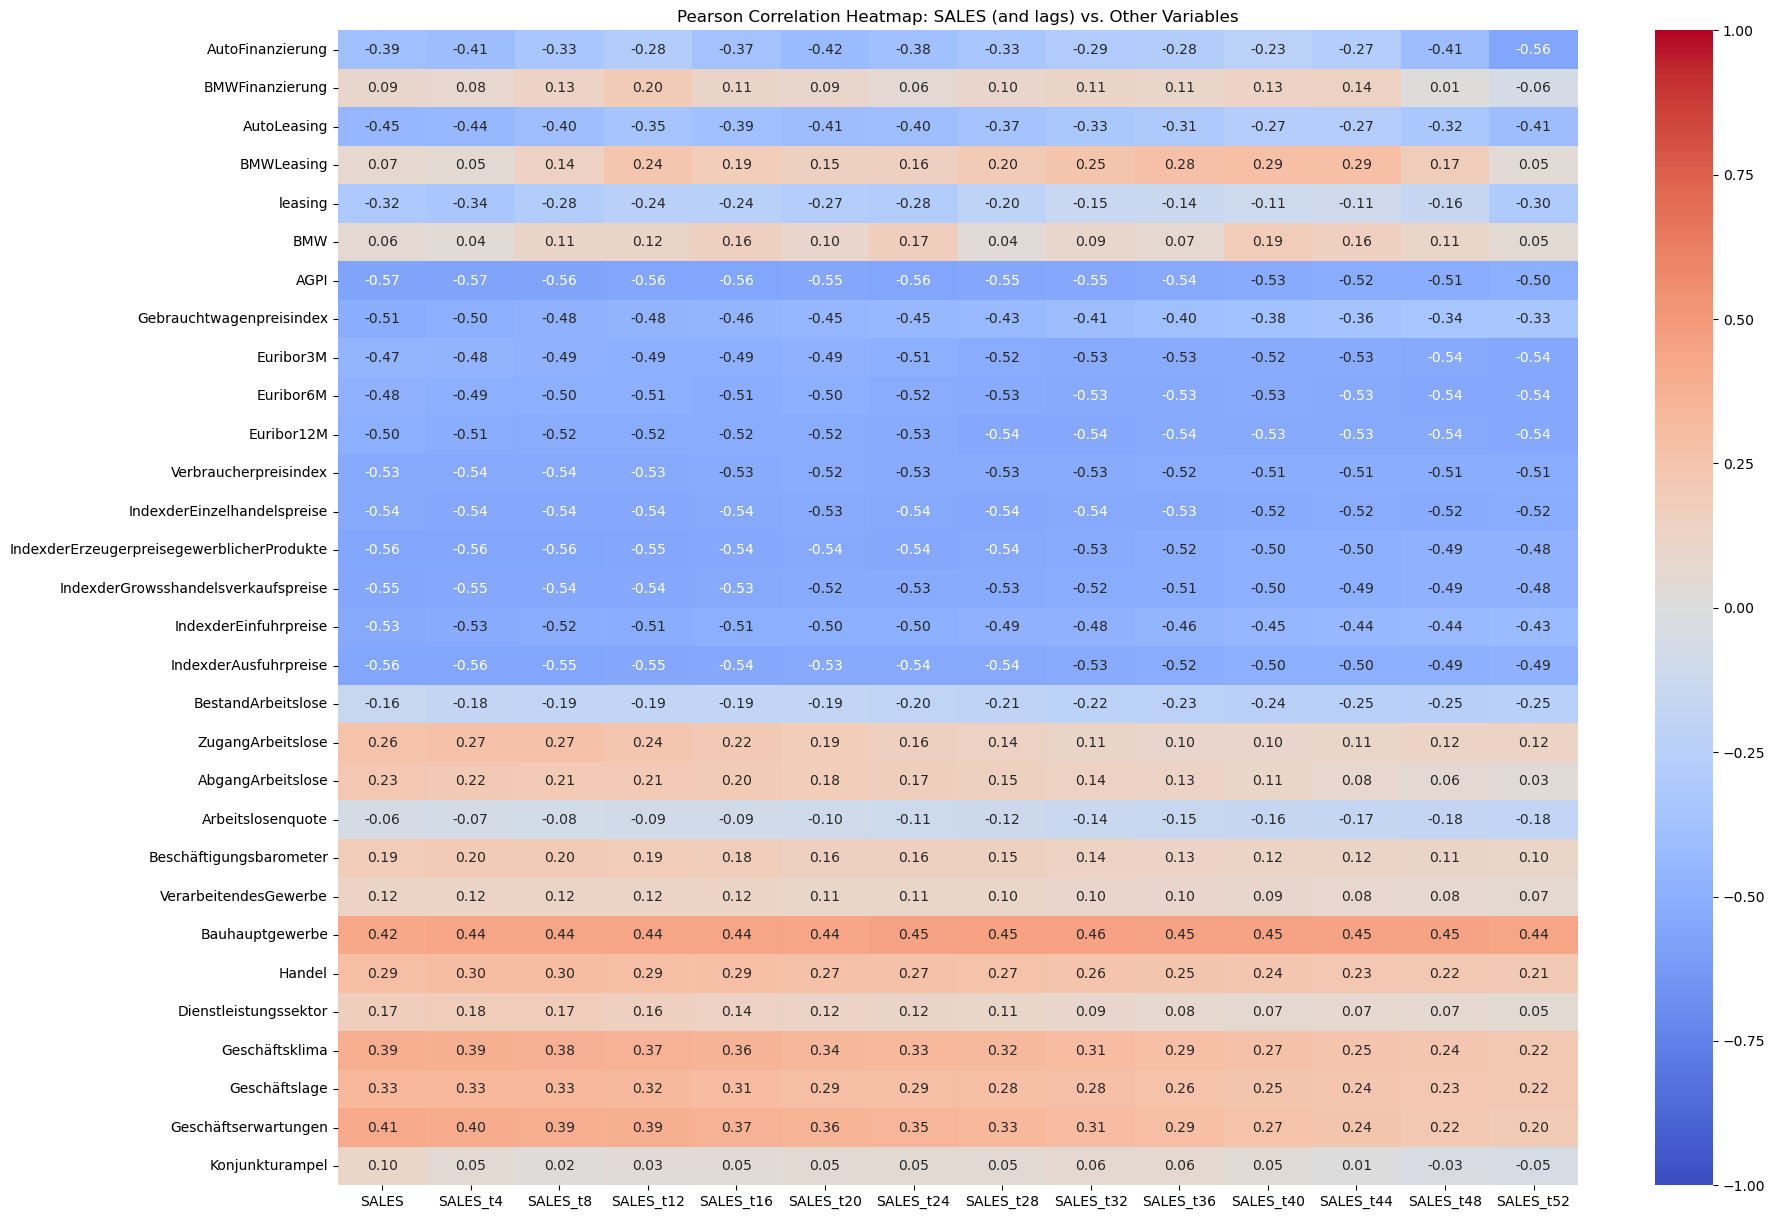


Pearson Correlation Subset:


,SALES,SALES_t4,SALES_t8,SALES_t12,SALES_t16,SALES_t20,SALES_t24,SALES_t28,SALES_t32,SALES_t36,SALES_t40,SALES_t44,SALES_t48,SALES_t52
AutoFinanzierung,-0.386296,-0.411712,-0.333618,-0.280942,-0.372943,-0.423152,-0.384037,-0.331441,-0.294935,-0.278676,-0.227831,-0.272273,-0.409163,-0.555353
BMWFinanzierung,0.092235,0.079297,0.125148,0.196369,0.110004,0.088130,0.059749,0.097396,0.111887,0.108097,0.130477,0.136165,0.011484,-0.060657
AutoLeasing,-0.452944,-0.440399,-0.401885,-0.352216,-0.386123,-0.409014,-0.401032,-0.366999,-0.327430,-0.306812,-0.271826,-0.271147,-0.322454,-0.407997
BMWLeasing,0.073383,0.050649,0.144406,0.237830,0.185051,0.152690,0.159163,0.198728,0.248695,0.277627,0.288202,0.285555,0.174231,0.046322
leasing,-0.317413,-0.342254,-0.278024,-0.235355,-0.244729,-0.272799,-0.283560,-0.204431,-0.146326,-0.138624,-0.114075,-0.106587,-0.160410,-0.299660
BMW,0.060304,0.043543,0.114849,0.115308,0.158068,0.100174,0.167011,0.038863,0.088288,0.065892,0.190671,0.157234,0.105246,0.051715
AGPI,-0.566247,-0.567939,-0.564499,-0.560486,-0.558452,-0.551699,-0.555518,-0.552757,-0.545645,-0.537768,-0.530338,-0.518799,-0.510497,-0.504206
Gebrauchtwagenpreisindex,-0.508259,-0.496271,-0.484122,-0.475342,-0.463231,-0.449128,-0.445195,-0.430456,-0.413253,-0.396624,-0.378686,-0.362051,-0.344364,-0.329410
Euribor3M,-0.466215,-0.475456,-0.486228,-0.493558,-0.494198,-0.490336,-0.505845,-0.518461,-0.526250,-0.527192,-0.524742,-0.529213,-0.537636,-0.540968
Euribor6M,-0.483453,-0.494836,-0.504410,-0.507745,-0.507821,-0.504557,-0.520214,-0.530465,-0.534845,-0.533663,-0.530904,-0.533704,-0.539102,-0.540955


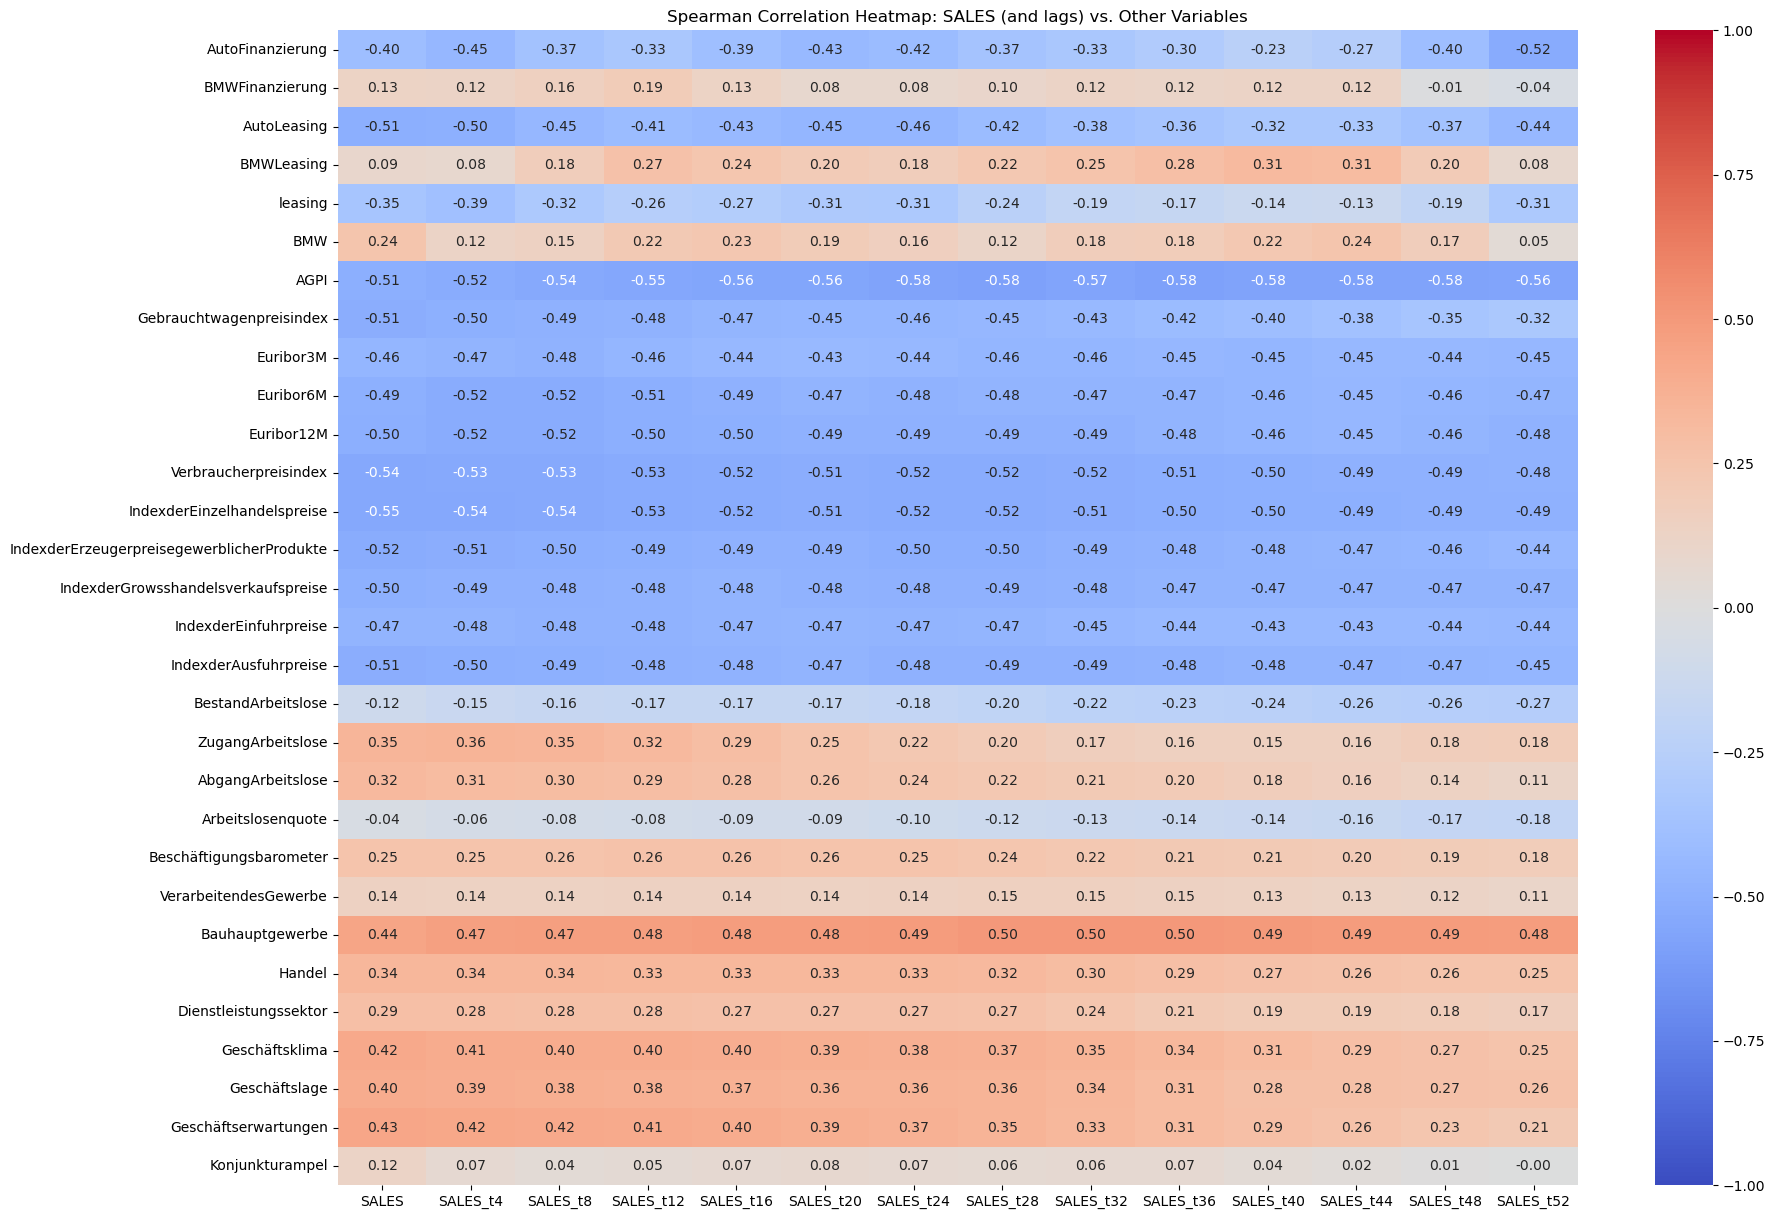


Spearman Correlation Subset:


,SALES,SALES_t4,SALES_t8,SALES_t12,SALES_t16,SALES_t20,SALES_t24,SALES_t28,SALES_t32,SALES_t36,SALES_t40,SALES_t44,SALES_t48,SALES_t52
AutoFinanzierung,-0.404680,-0.448680,-0.374639,-0.328441,-0.392712,-0.432944,-0.419637,-0.366674,-0.329129,-0.296829,-0.234697,-0.272619,-0.404177,-0.523804
BMWFinanzierung,0.132697,0.122877,0.155330,0.191869,0.132579,0.083868,0.078854,0.096865,0.124182,0.116493,0.122415,0.117752,-0.009440,-0.039831
AutoLeasing,-0.506538,-0.498485,-0.452814,-0.414486,-0.433845,-0.454222,-0.456179,-0.418981,-0.382415,-0.357847,-0.324849,-0.327090,-0.370248,-0.441225
BMWLeasing,0.091091,0.083832,0.177888,0.272986,0.235559,0.198972,0.177131,0.220567,0.253755,0.281291,0.314560,0.311821,0.197286,0.082366
leasing,-0.349617,-0.386402,-0.316063,-0.264478,-0.274002,-0.305361,-0.313165,-0.238387,-0.185696,-0.169149,-0.139820,-0.132719,-0.190246,-0.314543
BMW,0.242966,0.119415,0.147398,0.216981,0.231800,0.188989,0.156853,0.116547,0.177675,0.179889,0.223898,0.243408,0.173578,0.046161
AGPI,-0.506169,-0.517927,-0.536953,-0.553515,-0.560764,-0.559969,-0.575243,-0.580118,-0.570113,-0.584330,-0.577209,-0.577482,-0.576303,-0.563998
Gebrauchtwagenpreisindex,-0.508194,-0.496976,-0.486779,-0.480073,-0.465556,-0.454156,-0.456988,-0.446554,-0.430237,-0.417613,-0.398774,-0.377800,-0.348361,-0.323200
Euribor3M,-0.455948,-0.472149,-0.477472,-0.460652,-0.440360,-0.433649,-0.442771,-0.455256,-0.459294,-0.453081,-0.453258,-0.445289,-0.444292,-0.450516
Euribor6M,-0.494269,-0.516066,-0.521618,-0.506375,-0.488312,-0.474061,-0.478005,-0.476387,-0.472021,-0.469586,-0.459288,-0.450079,-0.455946,-0.467368


In [135]:
# correlation
# Define target columns (SALES and its lags)
target_cols = ["SALES"] + [f"SALES_t{i}" for i in range(4, 53, 4)]

# Define other columns (all columns except DATE and target_cols)
other_cols = [col for col in df_fe.columns if col not in target_cols + ["DATE"]]

correlation_methods = ["pearson", "spearman"]

for method in correlation_methods:
    # Calculate the correlation matrix between target_cols and other_cols
    correlation_matrix = df_fe[target_cols + other_cols].corr(method=method)

    # Select the relevant part of the correlation matrix
    # This shows the correlation of each 'other_col' with each 'target_col'
    correlation_subset = correlation_matrix.loc[other_cols, target_cols]

    # Plot the heatmap
    plt.figure(figsize=(20, 15))
    sns.heatmap(
        correlation_subset, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1
    )
    plt.title(
        f"{method.capitalize()} Correlation Heatmap: SALES (and lags) vs. Other Variables"
    )
    plt.show()

    print(f"\n{method.capitalize()} Correlation Subset:")
    display(correlation_subset)